In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression

from aiutils import copy_logistic_model, load
from actioncard import Chapel, Moat, Village, Militia, Moneylender, Smithy, CouncilRoom, Laboratory, Market, Witch
from config import GameConfig
from enums import StartingSplit, FeatureType
from env import DefaultEnvironment
from mcts import GameTree 
from mctsrunner import train_mcts
from player import init_players
from rollout import LogisticRegressionEnsembleRollout
from victorycard import Province

In [3]:
project_root = '/home/justiny/Documents/Projects/PyDominion'
model_dir = os.path.join(project_root, 'models')

## Full Dominion MCTS ##

In [41]:
tree_name = 'r-dw-mcts-bm-warm-start-100k-srat-base-default-ucb1-old-mlog'
rollout_name = 'mlog-10k-base-default-bm'
tree_path = os.path.join(model_dir, tree_name)
rollout_path = os.path.join(model_dir, rollout_name)

In [42]:
default_kingdom = [Chapel, Moat, Village, Militia, Moneylender, Smithy, CouncilRoom, Laboratory, Market, Witch]

In [10]:
# C = lambda x: max(1e-2, min(0.5, 1 / np.sqrt(x)))
C = lambda x: max(1 / np.sqrt(x + 2), 0.1)
# C = lambda x: 1 / np.sqrt(2)
tree = GameTree(train=True, C=C, selection='ucb1', _skip_level=False)

In [43]:
config = GameConfig(sandbox=False, num_players=2, must_include=default_kingdom)
players = init_players(['UCT', 'DW'], tree=tree, rollout_type='mlog')
# player = init_players(['UCT'], tree=tree, rollout_type='mlog')[0]
# players = [player, player]
agent = players[0]
# opp = players[1]
env = DefaultEnvironment(config, players)
idxs = env.game.state.feature.idxs 

In [32]:
rollout = LogisticRegressionEnsembleRollout(train=False)
agent.rollout = rollout

In [22]:
# rollout_name = 'default-mlog-100k'
rollout_name = 'default-mlog'
rollout_path = os.path.join(model_dir, rollout_name)
warm_models = load(rollout_path)['models']

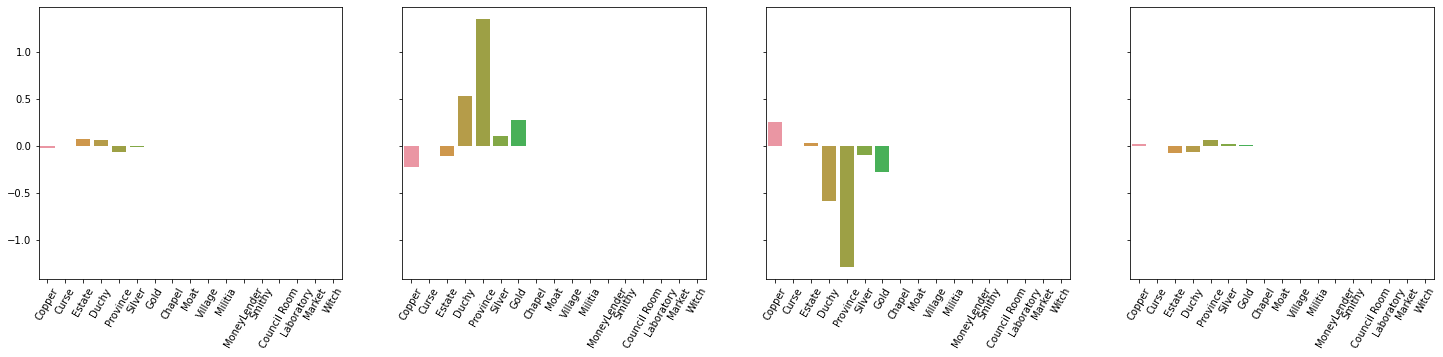

In [50]:
# plot_model = agent.rollout.models[8]
plot_model = rollout.models[3]

agent_weights = plot_model.coef_[0][17:34]
opp_weights = plot_model.coef_[0][34:]
supply_weights = plot_model.coef_[0][:17]
player_weight_diffs = agent_weights + opp_weights

cards = [str(k()) for k in idxs.keys()]

f, axes = plt.subplots(1,4, figsize=(25, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights, ax=axes[0])
sns.barplot(x=cards, y=agent_weights, ax=axes[1])
sns.barplot(x=cards, y=opp_weights, ax=axes[2])
sns.barplot(x=cards, y=player_weight_diffs, ax=axes[3])

for ax in axes: 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

In [13]:
train_mcts(env=env, tree=tree, epochs=100000, train_epochs_interval=sys.maxsize, save_epochs=10000, path=tree_path, rollout_path=rollout_path, scoring='score_ratio')

100%|██████████| 100000/100000 [43:22<00:00, 38.42it/s]


In [28]:
tree = GameTree.load(tree_path, train=False, _skip_level=False, selection='max')

## Sandbox MCTS Training ##

In [4]:
from buffer import Buffer

In [24]:
tree_name = 'r-r-mcts-bm-warm-start-sandbox-100k-srat'
rollout_name = 'sandbox-mlog-100k-10k-cap'
tree_path = os.path.join(model_dir, tree_name)
rollout_path = os.path.join(model_dir, rollout_name)

In [6]:
dataset_name = 'train-bm-bm-2k-full'
data_path = os.path.join(project_root, 'datasets', dataset_name)
raw_data = load(data_path)
X, y = raw_data[0], raw_data[1]

In [7]:
# C = lambda x: max(1e-2, min(0.5, 1 / np.sqrt(x)))
# C = lambda x: max(1 / np.sqrt(x + 2), 0.1)
C = lambda x: 1 / np.sqrt(2)
tree = GameTree(train=True, C=C, selection='ucb1', _skip_level=False)

In [8]:
config = GameConfig(sandbox=True, num_players=2, must_include=[])
# players = init_players(['UCT', 'DW'], tree=tree, rollout_type='mlog')
player = init_players(['UCT'], tree=tree, rollout_type='mlog')[0]
players = [player, player]
agent = players[0]
# opp = players[1]
env = DefaultEnvironment(config, players)
idxs = env.game.state.feature.idxs 

In [9]:
rollout = player.rollout
model_name = 'default-sandbox-warm-start'
model_path = os.path.join(model_dir, model_name)
# models = load(model_path)['models']
model = load(model_path)
rollout.models[8] = copy_logistic_model(model)

# for i, model in models.items():
#     if i == 0:
#         continue
#     rollout.models[i] = copy_logistic_model(model)

In [10]:
idxs = {'Copper': 0, 'Curse': 1, 'Estate': 2, 'Duchy': 3, 'Province': 4, 'Silver': 5, 'Gold': 6}
cards = list(idxs.keys())

In [11]:
filtered_X_idxs = [(i, x) for i, x in enumerate(X) if x[idxs['Province']] > 5]
filtered_X_idxs = [list(t) for t in zip(*filtered_X_idxs)]
filtered_X = filtered_X_idxs[1]
filtered_y = y[filtered_X_idxs[0]]
assert len(filtered_X) == len(filtered_y)
len(filtered_y)

40927

In [12]:
rollout.buffers[8] = Buffer(capacity=5000, locked_capacity=10000)

In [13]:
for i, x in enumerate(filtered_X):
    if i >= 20000:
        break 
    rollout.buffers[8].locked_store(x, filtered_y[i])

In [14]:
rollout.train = False

In [29]:
train_mcts(env=env, tree=tree, epochs=90000, train_epochs_interval=sys.maxsize, train_epochs_cap=sys.maxsize, save_epochs=10000, path=tree_path, rollout_path=rollout_path, scoring='score_ratio')

100%|██████████| 90000/90000 [34:28<00:00, 43.51it/s]


<AxesSubplot:>

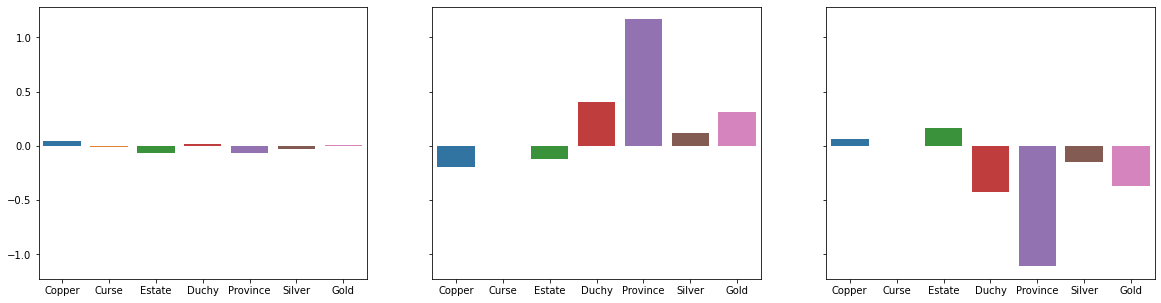

In [28]:
i=8
plot_model = player.rollout.models[4]
# plot_model = test_model

agent_weights = plot_model.coef_[0][7:14]
opp_weights = plot_model.coef_[0][14:]
supply_weights = plot_model.coef_[0][:7]
cards = [str(k()) for k in env.game.state.feature.idxs]

f, axes = plt.subplots(1,3, figsize=(20, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights, ax=axes[0])
sns.barplot(x=cards, y=agent_weights, ax=axes[1])
sns.barplot(x=cards, y=opp_weights, ax=axes[2])

In [106]:
agent_weights_comp = plot_model.coef_[0][7:14]
opp_weights_comp = plot_model.coef_[0][14:]
supply_weights_comp = plot_model.coef_[0][:7]
cards = list(env.game.state.feature.idxs.keys())

<AxesSubplot:>

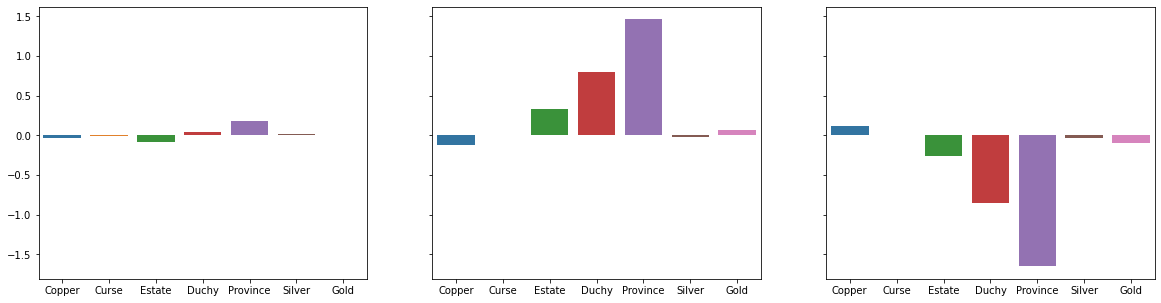

In [107]:
f, axes = plt.subplots(1,3, figsize=(20, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights_comp, ax=axes[0])
sns.barplot(x=cards, y=agent_weights_comp, ax=axes[1])
sns.barplot(x=cards, y=opp_weights_comp, ax=axes[2])